# Optimización del modelo alométrico longitud-anchura

Para profundizar en la optimización del modelo alométrico definido por la expresión matemática {eq}`eq_peso-longitud_anchura` es preciso adoptar una estrategia rigurosamente secuencial que combine diagnóstico estadístico exhaustivo, exploración de formas funcionales alternativas y validación externa. A lo largo de este capítulo analizaremos cada uno de estas fases de forma pormenorizada.

## 1. Preanálisis exploratorio
El objetivo de esta fase inicial es detectar y, en su caso, justificar la exclusión o el trato robusto de valores atípicos en el dataset que puedan sesgar el cálculo de los parámetros. Para ello se ha decidio no considerar en este análisis los datos de `Superficie (cm2)` ya que son el resultado de la operación $S=L \cdot A$ y no aporta información adicional, generando una colinealidad perfecta y por ello distornionando la detección multivariante.

In [10]:
# CARGA Y VISTA RÁPIDA DE DATOS
# --------------------------------

# Cargar librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (importado para scatter 3D)

sns.set(style="ticks", context="talk")    # estilo de gráficas
plt.rcParams["figure.figsize"] = (8, 5)   # tamaño base
plt.style.use('seaborn-v0_8-muted')

# Cargar el dataset
file_path = './data/Dimensiones_lenguado.xlsx'
df = pd.read_excel(file_path)

# Elimina/ignora cualquier columna que contenga 'superficie'
surface_cols = [c for c in df.columns if "superf" in c.lower()]
df = df.drop(columns=surface_cols, errors="ignore")  # errors="ignore" evita fallo si no existe

numeric_cols = ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)', 'Altura (cm)']

print("Forma:", df.shape)
display(df.head())
display(df.describe().transpose())


Forma: (209, 4)


,Peso (g),Longitud (cm),Anchura (cm),Altura (cm)
0,0.46,3.3,1.3,0.2
1,1.08,4.5,1.1,0.3
2,0.67,3.9,1.5,0.2
3,0.98,4.4,1.7,0.3
4,0.93,4.2,1.8,0.3


,count,mean,std,min,25%,50%,75%,max
Peso (g),209.0,5.344641,3.635514,0.46,2.82,4.29,6.96,21.98
Longitud (cm),209.0,7.244498,1.505369,3.30,6.10,7.00,8.30,11.40
Anchura (cm),209.0,2.788995,0.698297,1.10,2.30,2.70,3.30,5.20
Altura (cm),209.0,0.462679,0.117033,0.20,0.40,0.50,0.50,0.90


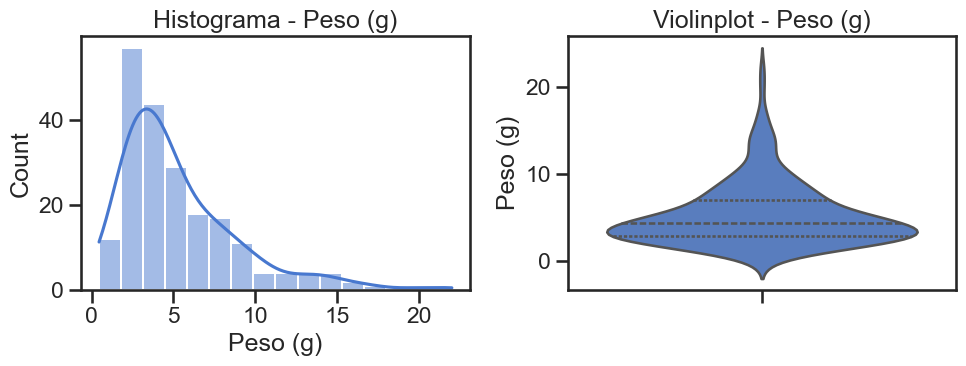

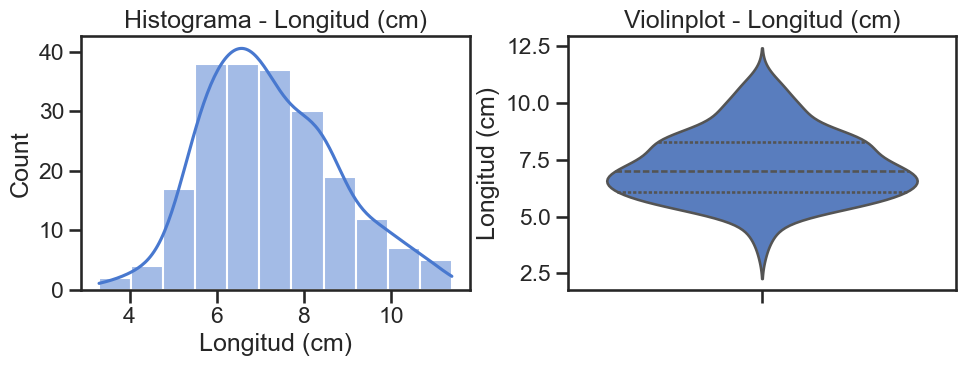

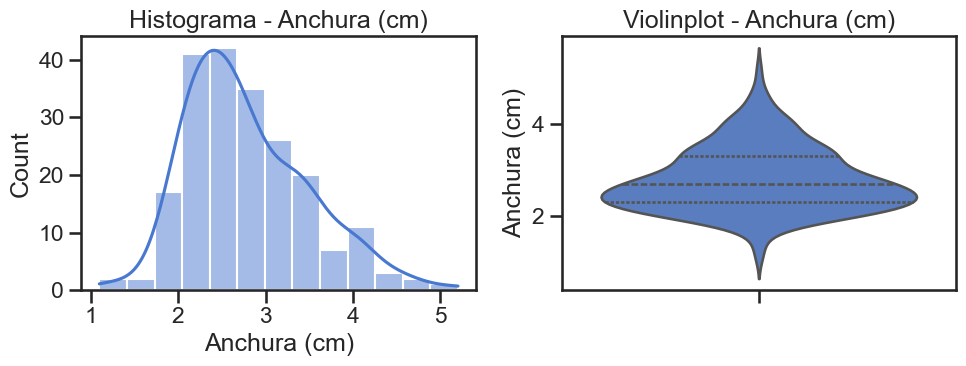

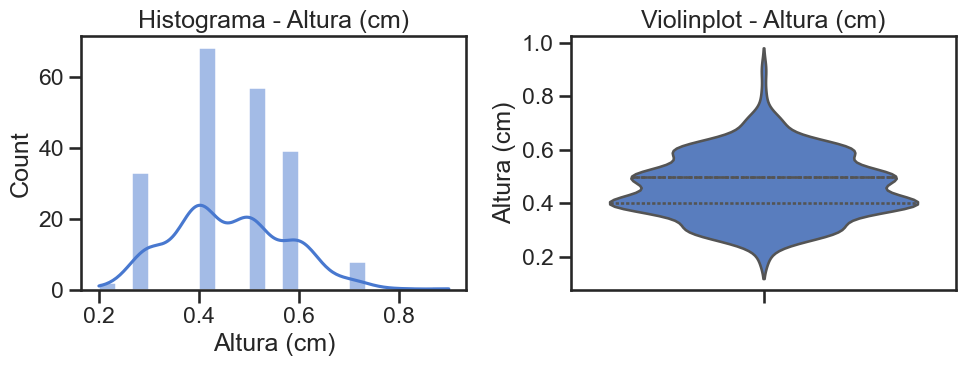

In [2]:
# DISTRIBUCIONES UNIVARIANTES
# ---------------------------

for col in numeric_cols:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(df[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Histograma - {col}")
    sns.violinplot(y=df[col], ax=ax[1], inner="quartile")
    ax[1].set_title(f"Violinplot - {col}")
    plt.tight_layout()

<table style="max-width:900px;width:100%;margin:auto;">
  <thead>
    <tr>
      <th style="background-color:#f2f2f2;font-weight:bold;border:1px solid #ccc;padding:6px;text-align:justify;">Variable</th>
      <th style="background-color:#f2f2f2;font-weight:bold;border:1px solid #ccc;padding:6px;text-align:justify;">Forma del violín</th>
      <th style="background-color:#f2f2f2;font-weight:bold;border:1px solid #ccc;padding:6px;text-align:justify;">Interpretación</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;"><strong>Peso&nbsp;(g)</strong></td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Ancho entre <strong>3 – 7 g</strong>, cola larga y estrecha hasta ≈ 22 g, varios puntos fuera del bigote superior.</td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Distribución <strong>fuertemente asimétrica a la derecha</strong>: la mayoría son ejemplares pequeños‑medios y unos pocos muy pesados (outliers).</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;"><strong>Longitud&nbsp;(cm)</strong></td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Violín casi simétrico, más ancho en 6 – 8 cm, cola superior corta, sin puntos fuera del bigote.</td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Distribución <strong>unimodal y estable</strong>; no hay valores extremos claros, buena candidata a predictor base.</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;"><strong>Anchura&nbsp;(cm)</strong></td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Pico ancho en 2,5 – 3,5 cm, cola superior hasta 5,2 cm con muy poca densidad, 1‑2 puntos aislados.</td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Forma similar a Longitud pero con <strong>cola alta leve</strong>; unos pocos peces muy anchos podrían ser anomalías o errores.</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;"><strong>Altura&nbsp;(cm)</strong></td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Violín estrecho (0,4 – 0,5 cm habituales), cola fina hasta 0,9 cm, varios puntos aislados arriba.</td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Variable con <strong>rango pequeño</strong>; valores altos destacan como outliers y podrían indicar errores de medición o casos excepcionales.</td>
    </tr>
  </tbody>
</table>

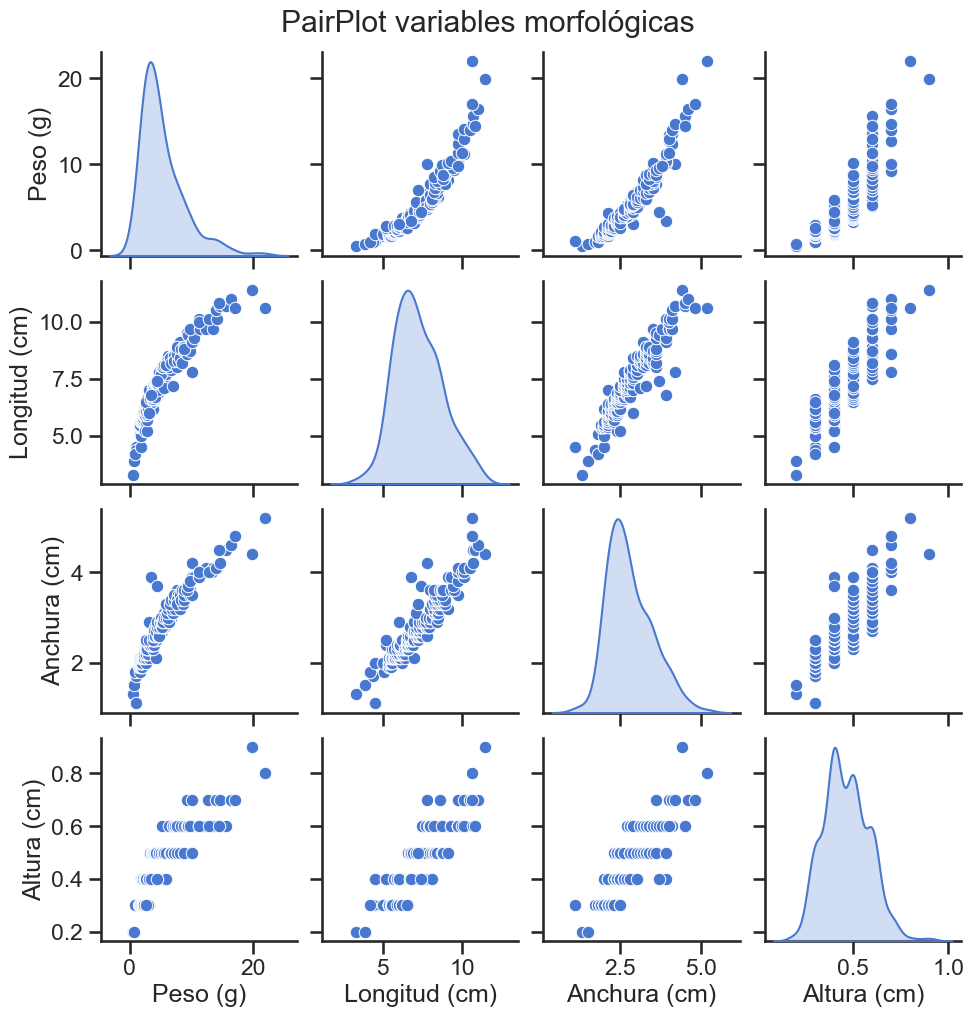

In [3]:
# MATRIZ DE DISPERSIÓN
# --------------------
sns.pairplot(df[numeric_cols], diag_kind="kde")
plt.suptitle("PairPlot variables morfológicas", y=1.02);

La matriz de dispersión revela un patrón claro de alometría: Peso crece exponencialmente con la Longitud y la Anchura, dibujando nubes curvilíneas donde los puntos se vuelven más dispersos a medida que el pez gana tamaño; eso confirma que la relación no es estrictamente lineal en escala original y justifica la transformación logarítmica aplicada en el modelo $W=kL^{a}A^{b}$. Longitud y Anchura mantienen entre sí una correlación positiva moderada los peces más largos tienden a ser más anchos mientras que Altura se agrupa fuertemente en torno a un intervalo estrecho y, salvo algunos valores altos anómalos, aporta poca variabilidad adicional. En todas las combinaciones que incluyen Peso se aprecian varios puntos solitarios por encima de la nube principal, lo que corrobora la presencia de outliers pesados detectados numéricamente. No se observan clusters separados que sugieran sub-poblaciones distintas, sino una gradación continua, de modo que los valores extremos se interpretan mejor como individuos excepcionales (o posibles errores) que como grupos diferenciados. **En conjunto, la dispersión respalda el uso de Longitud y Anchura como predictores principales, advierte sobre la influencia de los pesos extremos y confirma que la Altura puede excluirse sin pérdida sustancial de información.**

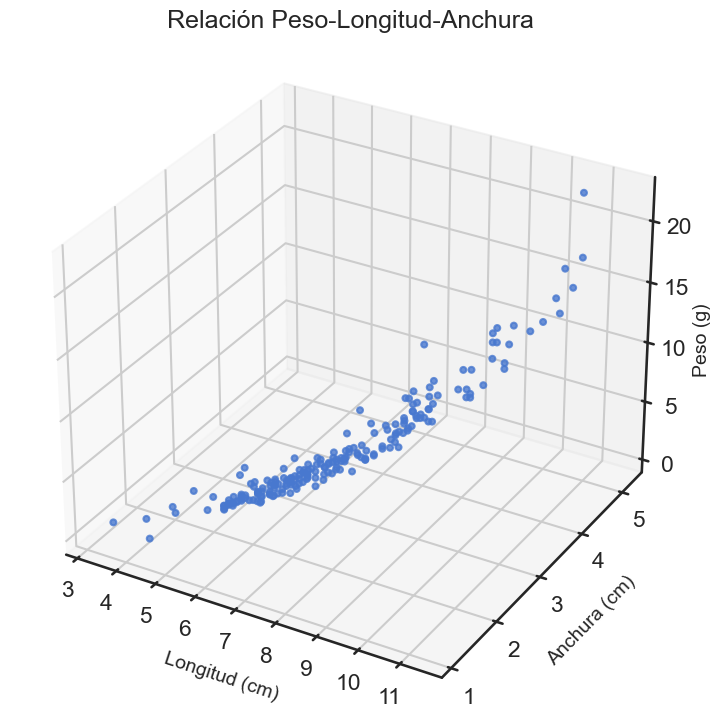

In [5]:
# SCATTER 3D PESO–LONGITUD–ANCHURA
# --------------------------------
fig = plt.figure(figsize=(8,8)) 
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Longitud (cm)'],
           df['Anchura (cm)'],
           df['Peso (g)'],
           s=18, alpha=0.8)

ax.set_xlabel('Longitud (cm)', labelpad=10, fontsize=14)
ax.set_ylabel('Anchura (cm)', labelpad=10, fontsize=14)
ax.set_zlabel('') # vaciamos el z-label “normal”

# Colocamos el texto como overlay 2-D para que no se recorte
fig.text(0.94, 0.52, 'Peso (g)', rotation=90,
         va='center', ha='center', fontsize=14)

ax.set_title("Relación Peso-Longitud-Anchura")
ax.set_box_aspect([1, 1, 0.8])  
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.90)
plt.show()


El diagrama de dispersión tridimensional obtenido muestra que los datos se distribuyen sobre una superficie típica de crecimiento alométrico: el peso ($W$) aumenta de forma supralineal con la longitud ($L$) y la anchura ($A$). Esta curvatura descarta cualquier ajuste plano clásico y avala la fórmula {eq}`eq_peso-longitud_anchura`; en coordenadas logarítmicas la nube se comprimiría prácticamente en un plano, lo que simplifica la estimación de $a$, $b$ y $k$ mediante regresión lineal múltiple sobre $\ln W$.

La sección horizontal del gráfico exhibe una correlación positiva marcada entre $L$ y $A$; sin embargo, la dispersión transversal confirma que la anchura aporta información independiente — es decir, $b$ no resulta redundante respecto a $a$. Además, la amplitud de la nube crece con el tamaño, evidenciando heterocedasticidad: los ejemplares grandes presentan mayor variabilidad relativa de peso. Este patrón exige, o bien la transformación log–log previa al ajuste, o bien el empleo de estimadores ponderados o robustos para preservar la validez inferencial.

En la proyección vertical se identifican varios individuos que se separan netamente de la masa principal: unos pocos muy pesados para su talla y uno o dos sorprendentemente livianos. Estos casos coinciden con los atípicos y deben revisarse individualmente —pudiendo tratarse de errores de registro, diferencias de condición corporal o etapas ontogénicas poco representadas.

**En conclusión, el análisis gráfico corrobora la idoneidad de un modelo alométrico en $L$ y $A$, subraya la necesidad de transformar logarítmicamente los datos o emplear métodos robustos y pone de relieve la importancia de manejar adecuadamente los valores atípicos para obtener estimaciones fiables de los parámetros biológicos.**

## 2. Visualización de *outliers*

En el análisis exploratorio se ha comprobado la existencia de *outliers* y su visualización es fundamental para comprender su impacto en la construcción del modelo predictivo. Estos valores atípicos pueden surgir por errores en la medición, variabilidad natural en la población o condiciones excepcionales, y su presencia puede distorsionar los parámetros estadísticos y sesgar el modelo de regresión. Al representar gráficamente los *outliers* se facilita la identificación de observaciones aberrantes que podrían afectar la linealidad, homocedasticidad o normalidad de los residuos. Además, su visualización permite evaluar si deben ser tratados mediante estrategias como winsorización, eliminación o imputación robusta, optimizando así la generalización del modelo.

Para contabilizar y visualizar estos *outliers* vamos a emplear primeramente un enfoque univariado (detección en una dimensión) para después aplicar un enfoque multivariado que permite la detección en múltiples variables.

### 2.1 Métodos univariados (detección en una dimensión)

- **Rango intercuartílico (IQR)** se define como la amplitud $Q_{3}-Q_{1}$, donde $Q_{1}$ y $Q_{3}$ son, respectivamente, los percentiles 25% y 75% de la distribución ordenada de una variable aleatoria continua. Constituye una medida robusta de dispersión, insensible a colas pesadas o valores aberrantes, pues encapsula el 50% central de las observaciones. En procedimientos de depuración de datos, el criterio aplicable considera atípica toda observación $x$ que verifique $x < Q_{1}-k\cdot \text{IQR}$ o $x > Q_{3}+k\cdot \text{IQR}$, con $k=1.5$ como valor convencional. Este umbral utiliza el IQR como escala de variabilidad intrínseca y permite identificar *outliers* sin asumir normalidad ni recurrir a momentos de orden superior, favoreciendo diagnósticos estadísticos robustos en muestras heterogéneas.
- **El Z-score**, o puntuación estándar, es una métrica estadística que cuantifica cuántas desviaciones estándar se aleja una observación del valor medio de la distribución, expresado como $Z=\dfrac{X−μ}{σ}$, donde $X$ es el valor observado, $μ$ la media poblacional y $σ$ la desviación estándar. Este método es particularmente útil para identificar *outliers* en distribuciones normales o aproximadamente normales, considerándose valores atípicos aquellos con $∣Z∣>3$ (umbral que abarca el 99.7% de los datos bajo la curva gaussiana). Sin embargo, su eficacia disminuye en distribuciones sesgadas o con colas pesadas, ya que la media y la desviación estándar son sensibles a valores extremos.


In [6]:
# -------------------------------------------------
#    METODOS UNIVARIADOS
# -------------------------------------------------
def iqr_mask(series, k=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (series < q1 - k*iqr) | (series > q3 + k*iqr)

# ********************************
#    IQR sobre cada variable
# ********************************
mask_iqr = (
    iqr_mask(df['Peso (g)']) |
    iqr_mask(df['Longitud (cm)']) |
    iqr_mask(df['Anchura (cm)'])
)

# Filtrar outliers y añadir columnas de diagnóstico
outliers_iqr = df[mask_iqr].copy()
outliers_iqr['Razón_outlier'] = ""

# Identificar qué variables contribuyeron

if 'Longitud (cm)' in df.columns:
    outliers_iqr.loc[iqr_mask(df['Longitud (cm)'])[mask_iqr], 'Razón_outlier'] += "Longitud; "
if 'Anchura (cm)' in df.columns:
    outliers_iqr.loc[iqr_mask(df['Anchura (cm)'])[mask_iqr], 'Razón_outlier'] += "Anchura; "
if 'Peso (g)' in df.columns:
    outliers_iqr.loc[iqr_mask(df['Peso (g)'])[mask_iqr], 'Razón_outlier'] += "Peso; "

# Mostrar resultado
print(f"IQR: Número de outliers detectados IQR: {len(outliers_iqr)}\n")
outliers_iqr.head(len(outliers_iqr))

IQR: Número de outliers detectados IQR: 11



,Peso (g),Longitud (cm),Anchura (cm),Altura (cm),Razón_outlier
194,13.45,9.7,4.0,0.6,Peso;
197,13.56,9.7,4.1,0.6,Peso;
200,14.13,10.1,4.1,0.7,Peso;
201,14.04,10.5,4.1,0.7,Peso;
202,14.67,10.7,4.2,0.7,Peso;
203,15.65,10.7,4.5,0.6,Peso;
204,14.50,10.8,4.5,0.6,Peso;
205,19.88,11.4,4.4,0.9,Peso;
206,16.47,11.0,4.6,0.7,Peso;
207,17.04,10.6,4.8,0.7,Peso;


In [7]:
# ********************************
#    Z-SCORE sobre cada variable
# ********************************

from scipy.stats import zscore

def zscore_mask(series, threshold=3):
    z_scores = zscore(series)
    return abs(z_scores) > threshold

mask_zscore = (
    zscore_mask(df['Peso (g)']) |
    zscore_mask(df['Longitud (cm)']) |
    zscore_mask(df['Anchura (cm)'])
)

# Filtrar outliers y añadir columnas de diagnóstico
outliers_zscore = df[mask_zscore].copy()
outliers_zscore['Razón_outlier'] = ""

# Añadir Z-scores para cada variable
for col in ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)']:
    if col in df.columns:
        outliers_zscore[f'Z_{col}'] = zscore(df[col])[mask_zscore]

# Identificar qué variables contribuyeron
if 'Longitud (cm)' in df.columns:
    outliers_zscore.loc[zscore_mask(df['Longitud (cm)'])[mask_zscore], 'Razón_outlier'] += "Longitud; "
if 'Anchura (cm)' in df.columns:
    outliers_zscore.loc[zscore_mask(df['Anchura (cm)'])[mask_zscore], 'Razón_outlier'] += "Anchura; "
if 'Peso (g)' in df.columns:
    outliers_zscore.loc[zscore_mask(df['Peso (g)'])[mask_zscore], 'Razón_outlier'] += "Peso; "

# Mostrar resultado
print(f"Z-Score: Número de outliers detectados (|Z| > 3): {len(outliers_zscore)}\n")
display(outliers_zscore.style.format({f'Z_{col}': "{:.2f}" for col in ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)'] if col in df.columns}))

Z-Score: Número de outliers detectados (|Z| > 3): 4



,Peso (g),Longitud (cm),Anchura (cm),Altura (cm),Razón_outlier,Z_Peso (g),Z_Longitud (cm),Z_Anchura (cm)
205,19.880000,11.400000,4.400000,0.900000,Peso;,4.01,2.77,2.31
206,16.470000,11.000000,4.600000,0.700000,Peso;,3.07,2.50,2.60
207,17.040000,10.600000,4.800000,0.700000,Peso;,3.22,2.23,2.89
208,21.980000,10.600000,5.200000,0.800000,Anchura; Peso;,4.59,2.23,3.46


### 2.2 Métodos multivariados

**Isolation Forest** es un algoritmo de detección de anomalías no supervisado basado en el principio de particiones aleatorias. A partir de un conjunto de $n$ observaciones $\{\mathbf{x}{i}\}{i=1}^{n}\subset\mathbb{R}^{p}$, se construye un bosque de $t$ árboles binarios denominados *iTrees*; cada *iTree* se genera seleccionando recursivamente, de forma aleatoria, (i) una característica $j\in\{1,\dots,p\}$ y (ii) un valor de corte $\theta$ comprendido entre los valores mínimo y máximo de la característica en el subconjunto actual. El proceso continúa hasta que la partición contiene un único punto o alcanza una profundidad máxima $h_{\max}$. La idea fundamental es que las observaciones anómalas, al hallarse escasamente representadas y en regiones periféricas del espacio de características, tienden a quedar aisladas tras un número bajo de divisiones. Para cada muestra $\mathbf{x}$ se define una profundidad promedio $E[h(\mathbf{x})]$ —promediada sobre los $t$ árboles— y de ella se deduce la puntuación de anomalía

```{math}
:label: eq_iforest_1
s(\mathbf{x}) = 2^{-\frac{E[h(\mathbf{x})]}{c(n)}},
\qquad
c(n) = H_{n-1}-\frac{2(n-1)}{n},
```

donde $H_{n}$ es el $n$-ésimo número armónico. Los valores de $s(\mathbf{x})$ se normalizan en $[0,1]$; puntuaciones próximas a 1 indican observaciones susceptibles de ser outliers. El esquema evita suposiciones paramétricas sobre la forma de la distribución, es eficiente en alta dimensionalidad $(O(t\,n\log n))$ y permite fijar *a priori* la proporción esperada de anomalías mediante el parámetro `contamination`, lo que lo hace idóneo para depuración robusta de conjuntos de datos complejos. 

Para abordar este algoritmo eliminamos de nuestro *dataset* la variable `Altura` porque como ya concluimos anteriormente su exclusión no produce pérmida fundamental de información y sí podria afectar a los resultados. Previamente a la aplicacion del algoritmo es necesario normalizar (estandarizar) las columnas seleccionadas para garantizar la efectividad del algoritmo en la detección de anomalías. Al estandarizar las variables mediante la transformación $\dfrac{X−μ}{σ}$, se homogenizan las escalas de todas las características, evitando que aquellas con magnitudes mayores dominen artificialmente el cálculo de anomalías. Este paso es esencial porque *Isolation Forest*, al basarse en particiones aleatorias del espacio de características, puede generar sesgos en conjuntos de datos con variables en escalas heterogéneas. La estandarización no solo mejora la sensibilidad del modelo a patrones multivariados de *outliers*, sino que también facilita la interpretación de los *scores* de anomalía al operar en un espacio métrico coherente. Adicionalmente, al fijar la media en 0 y la varianza en 1, se optimiza el rendimiento computacional del algoritmo, ya que las distancias utilizadas en las particiones aleatorias de los árboles reflejan contribuciones equilibradas de todas las variables.

Nº de outliers detectados: 36


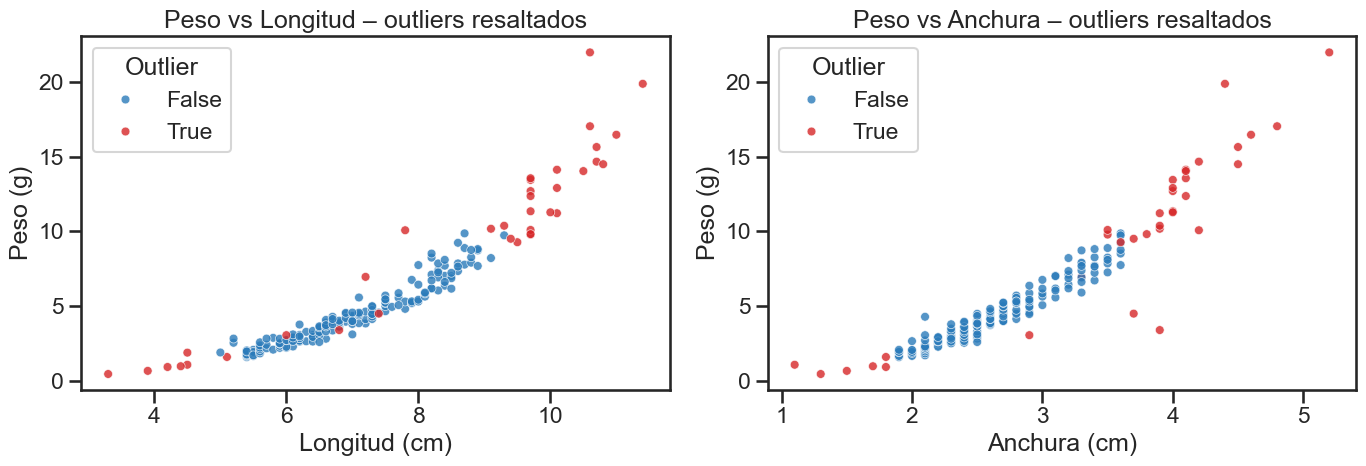

In [11]:
# ********************************
#  ISOLATION FOREST MULTIVARIABLE
# ********************************

iso = IsolationForest(contamination='auto', random_state=42)

# Eliminamos la columna altura del dataset
iso_cols = ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)']
X = df[iso_cols]

# Normalizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

labels_iso = iso.fit_predict(X_scaled)
mask_iso = labels_iso == -1

# c) Outlier si lo marca al menos uno de los dos métodos
df['is_outlier'] = mask_iqr | mask_iso

print(f"Nº de outliers detectados: {df['is_outlier'].sum()}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica 1
sns.scatterplot(data=df, x='Longitud (cm)', y='Peso (g)',
                hue='is_outlier', ax=ax1,
                palette={False: "#2b7bba", True: "#d62728"},
                alpha=0.8, s=40)
ax1.set_title("Peso vs Longitud – outliers resaltados")
ax1.legend(title="Outlier", loc="upper left")

# Gráfica 2
sns.scatterplot(data=df, x='Anchura (cm)', y='Peso (g)',
                hue='is_outlier', ax=ax2,
                palette={False: "#2b7bba", True: "#d62728"},
                alpha=0.8, s=40)
ax2.set_title("Peso vs Anchura – outliers resaltados")
ax2.legend(title="Outlier", loc="upper left")

plt.tight_layout()
plt.show()